# Проект "Телекоммуникации"

## Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.  

Оператор предоставляет два основных типа услуг:   
* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.  
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
  
Также доступны такие услуги:  
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);   
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

## Цель проекта

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Необходимо обучить на этих данных модель для прогноза оттока клиентов

## Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:
* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.

В файле **contract_new.csv** содержится следующая информация:  
**customerID** — идентификатор абонента;  
**BeginDate** — дата начала действия договора;  
**EndDate** — дата окончания действия договора;  
**Type** — тип оплаты: раз в год-два или ежемесячно;  
**PaperlessBilling** — электронный расчётный лист;  
**PaymentMethod** — тип платежа;  
**MonthlyCharges** — расходы за месяц;  
**TotalCharges** — общие расходы абонента.  

В файле **personal_new.csv** содержится следующая информация:   
**customerID** — идентификатор пользователя;  
**gender** — пол;  
**SeniorCitizen** — является ли абонент пенсионером;  
**Partner** — есть ли у абонента супруг или супруга;  
**Dependents** — есть ли у абонента дети.  

В файле **internet_new.csv** содержится следующая информация:  
**customerID** — идентификатор пользователя;  
**InternetService** — тип подключения;  
**OnlineSecurity** — блокировка опасных сайтов;  
**OnlineBackup** — облачное хранилище файлов для резервного копирования данных;  
**DeviceProtection** — антивирус;  
**TechSupport** — выделенная линия технической поддержки;  
**StreamingTV** — стриминговое телевидение;  
**StreamingMovies** — каталог фильмов.

В файле **phone_new.csv** содержится следующая информация:   
**customerID** — идентификатор пользователя;  
**MultipleLines** — подключение телефона к нескольким линиям одновременно.  

Информация о договорах актуальна на 1 февраля 2020 года.

## План работы

1. [Изучить данные и провести их предварительную обработку. При необходимости сгенерировать новые признаки.](Загрузка-и-предобработка-данных) 
2. [Провести исследовательский анализ данных для каждой категории клиентов.](Исследовательский-анализ-данных)
3. [Изучить корреляцию между признакам.](Корреляционный-анализ-данных)
4. [Подготовить данные и обучить несколько моделей для прогнозирования оттока клиентов на тренировочной выборке. В связи с тем, что в данной задаче необходимо минимизировать как ложноположительные, так и ложноотрицательные результаты, для оценки качества прогнозов моделей будет использована метрика ROC AUC.](Обучение-моделей)
5. [Выбрать лучшую модель и оценить ее качество на тестовой выборке.](Анализ-лучшей-модели)

# Импорт библиотек

In [1]:
!pip -q install phik

In [2]:
!pip -q install CatBoost

In [3]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier

import os
import phik

# Константы

In [4]:
RANDOM_STATE = 231224
TEST_SIZE = 0.25

# Используемые функции

## Общая информация о датасете

In [5]:
def info(df):
    display(df.head())
    print('____')
    print(df.info())
    print('____')
    print(pd.DataFrame(df.isna().sum(), columns=['Количество пропусков']))
    print('____')
    print(f'Количество дубликатов: {df.duplicated().sum()}')
    print('____')
    print(f'Названия столбцов: {df.columns}')

## Поиск уникальных значений в столбцах со значениями типа object

In [6]:
def unique_object(df):
    for column in df.columns:
        if df[column].dtype==object:
            print(column, df[column].unique())

## Графики для количественных признаков

In [7]:
def num_target_plot(df, target_column, discrete_features=None):
    
    num_col = df.select_dtypes(include='number').columns
    num_col = num_col[num_col != target_column] 

    if discrete_features:
        num_col = num_col.drop(discrete_features)
        
    for column in num_col:
          
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            sns.histplot(data=df, x=column, hue=target_column, multiple="stack", palette='Accent', kde=True)
            plt.title(f'Гистограмма для {column}\n в разбивке по целевому признаку')
        
            plt.subplot(1, 2, 2)
            sns.boxplot(data=df, x=target_column, y=column, palette='Accent')
            plt.title(f'Ящик с усами для {column}\n в разбивке по целевому признаку')
            plt.show()
        
    if discrete_features:
        for column in discrete_features:
            plt.figure(figsize=(7, 4))
            sns.countplot(x=df[column], hue=df[target_column], palette='Accent')
            plt.title(column)
            plt.show()

## Круговая диаграмма в разбивке по целевому признаку

In [8]:
def cat_target_plot(df, target_column):
    cat_col = df.select_dtypes(exclude='number').columns
    
    for column in cat_col:
        if column != target_column:
            
            fig, axes = plt.subplots(1, 2, figsize=(9, 3)) 
           
            
            for i, value in enumerate(df[target_column].unique()):
                df_target_value = df[df[target_column] == value]
                
             
                df_target_value[column].value_counts().plot(
                    ax=axes[i],  
                    kind='pie',
                    autopct='%1.0f%%', 
                    colors=sns.color_palette('pastel', df[column].nunique()),
                    title=f'{column} (Target = {value})'
                )
                axes[i].set_ylabel('')  
            
            plt.show()

## Разбивка на тренировочную и тестовую выборки (в соотношении 75:25)

In [9]:
def df_split(df, target):
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size = TEST_SIZE, stratify=y)
    print(f'Размер тренировочных выборок: {X_train.shape}, {y_train.shape}.\
    Размер тестовых выборок {X_test.shape}, {y_test.shape}')
    return X_train, X_test, y_train, y_test

## Матрица корреляций

In [10]:
def phik(df,interval_cols): 
    phik_corr = df.phik_matrix(interval_cols)
    plt.figure(figsize=(15, 7))
    sns.heatmap(phik_corr, annot=True, cmap='cividis', annot_kws={"size": 12})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Матрица корреляций ϕk', fontsize=20);

## Кодирование признаков с использованием OneHotEncoder

In [11]:
def ohe(X_train, X_test, ohe_columns):

    ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    X_train_ohe = ohe.fit_transform(X_train[ohe_columns])
    one_hot_encoder_col_names_train = ohe.get_feature_names_out(ohe_columns)
    X_train_df = pd.DataFrame(X_train_ohe, columns=one_hot_encoder_col_names_train, index=X_train.index)
    X_train_encoded = X_train.drop(columns=ohe_columns).join(X_train_df)


    X_test_ohe = ohe.transform(X_test[ohe_columns])
    one_hot_encoder_col_names_test = ohe.get_feature_names_out(ohe_columns)
    X_test_df = pd.DataFrame(X_test_ohe, columns=one_hot_encoder_col_names_test, index=X_test.index)
    X_test_encoded = X_test.drop(columns=ohe_columns).join(X_test_df)
    
    return X_train_encoded, X_test_encoded

## Анализ важности признаков

In [12]:
def plot_feature_importances(model, feature_columns, name, figsize=(8, 5)):
   
    feature_importances = model.feature_importances_

   
    features_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    
    plt.figure(figsize=figsize)
    plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
    plt.gca().invert_yaxis()
    plt.xlabel('Важность признаков')
    plt.title(f'Важность признаков для модели {name}')
    plt.show()

## Матрица ошибок

In [13]:
def conf_matrix(y_true, y_pred, name):
 
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Матрица ошибок модели {name}')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.show()

# Загрузка и предобработка данных

## Датасет contract_new

In [14]:
pth1 = 'C:/Users/knadi/Desktop/итоговый проект/contract_new.csv'
pth2 = '/datasets/contract_new.csv'

if os.path.exists(pth1):
    contract = pd.read_csv(pth1)
elif os.path.exists(pth2):
    contract = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [15]:
info(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


____
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
____
                  Количество пропусков
customerID                           0
BeginDate                            0
EndDate                              0
Type                                 0
PaperlessBilling                     0
PaymentMethod                        0
MonthlyCharges                       0
TotalCharges                         0
____

Переименование столбцов:

In [16]:
contract = contract.rename(columns={'customerID': 'customer_id', 'BeginDate': 'begin_date', 'EndDate': 'end_date',
                                    'Type': 'type', 'PaperlessBilling': 'paperless_billing', 'PaymentMethod': 'payment_method', 
                                    'MonthlyCharges': 'monthly_charges', 'TotalCharges': 'total_charges'})

Изменение типа данных в столбце total_charges: 

In [17]:
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')

In [18]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


После изменения типа данных появились пропуски в столбце total_charges.

In [19]:
unique_object(contract)

customer_id ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
begin_date ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-1

In [20]:
contract[contract['end_date']=='No']['customer_id'].count()

5942

В столбце end_date вместо даты у 5942 клиентов присутствует значение "NO". Очевидно, что это характерно для клиентов, чьи договора действуют на 1 февраля 2020 года, т.е. данный признак можно рассматривать как целевой: "NO" - клиент остался, либо клиент ушел, если в столбце указана конкретная дата. 

In [21]:
contract['target'] = contract['end_date'].apply(lambda x: 0 if x == 'No' else 1)

In [22]:
contract['target'].value_counts(normalize=True).round(2)

0    0.84
1    0.16
Name: target, dtype: float64

Наблюдается сильный дисбаланс классов: только 16 % клиентов расторгли договор. Дисбаланс следует учесть при разбивке выборки на тренировчную и тестовую. 

Для удобства анализа  переведем даты в столбцах begin_date и end_date к формату datetime. Добавим новые признаки с количеством дней пользования услугами компании, годом и месяцем регистрации.

In [23]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'])

contract['end_date'] = contract['end_date'].replace('No', '2020-02-01')
contract['end_date'] = pd.to_datetime(contract['end_date'])

In [24]:
contract['days'] = (contract['end_date'] - contract['begin_date']).dt.days.astype('int16')
contract['begin_year'] = contract['begin_date'].dt.year.astype('int16')
contract['begin_month'] = contract['begin_date'].dt.month.astype('int16')

In [25]:
contract = contract.drop(columns=['begin_date'])
contract = contract.drop(columns=['end_date'])

In [26]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7032 non-null   float64
 6   target             7043 non-null   int64  
 7   days               7043 non-null   int16  
 8   begin_year         7043 non-null   int16  
 9   begin_month        7043 non-null   int16  
dtypes: float64(2), int16(3), int64(1), object(4)
memory usage: 426.6+ KB


In [27]:
contract.describe()

,monthly_charges,total_charges,target,days,begin_year,begin_month
count,7043.000000,7032.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2118.621822,0.156325,898.555729,2016.878603,6.421269
std,30.090047,2112.736199,0.363189,683.130510,1.970573,3.578453
min,18.250000,19.050000,0.000000,0.000000,2013.000000,1.000000
25%,35.500000,439.745000,0.000000,276.000000,2015.000000,3.000000
50%,70.350000,1345.275000,0.000000,761.000000,2017.000000,6.000000
75%,89.850000,3239.317500,0.000000,1461.000000,2019.000000,10.000000
max,118.750000,9221.380000,1.000000,2314.000000,2020.000000,12.000000


*Получена общая информация о датасете contract. Было проведено переименование столбцов и изменение типа данных в столбце с суммарными расходами. Неявные дубликаты в категориальных признаках не обнаружены. Имеются пропуски в столбце total_charges. Также стоит отметить, что первые договоры с клиентами были заключены в октябре 2013 года. Добавлено 3 новых признака с месяцем и годом регистрации пользователя и количесством дней пользования услугами компании. Признаки "end_date" и "begin_date" удалены. Выделен целевой признак.*

## Датасет personal_new

In [28]:
pth3 = 'C:/Users/knadi/Desktop/итоговый проект/personal_new.csv'
pth4 = '/datasets/personal_new.csv'

if os.path.exists(pth3):
    personal = pd.read_csv(pth3)
elif os.path.exists(pth4):
    personal = pd.read_csv(pth4)
else:
    print('Something is wrong')

In [29]:
info(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


____
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
____
               Количество пропусков
customerID                        0
gender                            0
SeniorCitizen                     0
Partner                           0
Dependents                        0
____
Количество дубликатов: 0
____
Названия столбцов: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')


Переименование столбцов:

In [30]:
personal = personal.rename(columns={'customerID': 'customer_id', 'SeniorCitizen': 'senior_citizen',
                                   'Partner': 'partner', 'Dependents': 'dependents'})

In [31]:
personal['senior_citizen'] = personal['senior_citizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

In [32]:
unique_object(personal)

customer_id ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
senior_citizen ['No' 'Yes']
partner ['Yes' 'No']
dependents ['No' 'Yes']


*Получена общая информация о датасете personal. Проведено переименование столбцов. Неявные дубликаты в категориальных признаках не обнаружены. Пропуски и дубликаты отсутствуют.*

## Датасет internet_new

In [33]:
pth5 = 'C:/Users/knadi/Desktop/итоговый проект/internet_new.csv'
pth6 = '/datasets/internet_new.csv'

if os.path.exists(pth5):
    internet = pd.read_csv(pth5)
elif os.path.exists(pth6):
    internet = pd.read_csv(pth6)
else:
    print('Something is wrong')

In [34]:
info(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


____
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
____
                  Количество пропусков
customerID                           0
InternetService                      0
OnlineSecurity                       0
OnlineBackup                         0
DeviceProtection                     0
TechSupport                          0
StreamingTV                          0
StreamingMovies                      0
____
Количество дубликатов

Переименование столбцов:

In [35]:
internet = internet.rename(columns={'customerID': 'customer_id', 'InternetService': 'internet_service',
                                   'OnlineSecurity': 'online_security', 'OnlineBackup': 'online_backup',
                                   'DeviceProtection': 'device_protection', 'TechSupport': 'tech_support',
                                   'StreamingTV': 'streaming_tv', 'StreamingMovies': 'streaming_movies'})

In [36]:
unique_object(internet)

customer_id ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
internet_service ['DSL' 'Fiber optic']
online_security ['No' 'Yes']
online_backup ['Yes' 'No']
device_protection ['No' 'Yes']
tech_support ['No' 'Yes']
streaming_tv ['No' 'Yes']
streaming_movies ['No' 'Yes']


*Получена общая информация о датасете internet. Проведено переименование столбцов. Неявные дубликаты в категориальных признаках не обнаружены. Пропуски и дубликаты отсутствуют. Стоит отметить, что не все клиенты компании "Теледом" пользуются интернетом от данного провайдера, а только 5517 из 7043.*

## Датасет phone_new

In [37]:
pth7 = 'C:/Users/knadi/Desktop/итоговый проект/phone_new.csv'
pth8 = '/datasets/phone_new.csv'

if os.path.exists(pth7):
    phone = pd.read_csv(pth7)
elif os.path.exists(pth8):
    phone = pd.read_csv(pth8)
else:
    print('Something is wrong')

In [38]:
info(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


____
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
____
               Количество пропусков
customerID                        0
MultipleLines                     0
____
Количество дубликатов: 0
____
Названия столбцов: Index(['customerID', 'MultipleLines'], dtype='object')


Переименование столбцов:

In [39]:
phone = phone.rename(columns={'customerID': 'customer_id', 'MultipleLines': 'multiple_lines'})

In [40]:
unique_object(phone)

customer_id ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
multiple_lines ['No' 'Yes']


*Получена общая информация о датасете phone. Проведено переименование столбцов. Неявные дубликаты в категориальных признаках не обнаружены. Пропуски и дубликаты отсутствуют.*

## Объединение данных

In [41]:
data = contract.merge(personal, on = 'customer_id', how='left')
data = data.merge(internet, on = 'customer_id', how='left')
data = data.merge(phone, on = 'customer_id', how='left')

In [42]:
data.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,target,days,begin_year,begin_month,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,2020,1,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,2017,4,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,2019,10,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,2016,5,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,2019,9,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7032 non-null   float64
 6   target             7043 non-null   int64  
 7   days               7043 non-null   int16  
 8   begin_year         7043 non-null   int16  
 9   begin_month        7043 non-null   int16  
 10  gender             7043 non-null   object 
 11  senior_citizen     7043 non-null   object 
 12  partner            7043 non-null   object 
 13  dependents         7043 non-null   object 
 14  internet_service   5517 non-null   object 
 15  online_security    5517 non-null   object 
 16  online_backup      5517 

In [44]:
data[data['total_charges'].isnull()]

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,target,days,begin_year,begin_month,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
488,4472-LVYGI,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0,2020,2,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,Two year,No,Mailed check,20.25,NaN,0,0,2020,2,...,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,Two year,No,Mailed check,80.85,NaN,0,0,2020,2,...,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,Two year,No,Mailed check,25.75,NaN,0,0,2020,2,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,Two year,No,Credit card (automatic),56.05,NaN,0,0,2020,2,...,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,Two year,No,Mailed check,19.85,NaN,0,0,2020,2,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,Two year,No,Mailed check,25.35,NaN,0,0,2020,2,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,Two year,No,Mailed check,20.00,NaN,0,0,2020,2,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,One year,Yes,Mailed check,19.70,NaN,0,0,2020,2,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,Two year,No,Mailed check,73.35,NaN,0,0,2020,2,...,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


Пропуски в столбце с общими расходами связаны с тем, что договор был заключен 01.02.2020. Данные не являются показательными, т.к. очевидно, что клиент не расторгнет договор сразу после заключения. Исходя из того, что эти клиенты могут попасть в обучающую выборку, их следует удалить.

In [45]:
data = data.dropna(subset=['total_charges'])

Очевидно, что не все клиенты пользуются одновременно и интернетом и услугами телефонной связи. Пропуски в столбце multiple_lines можно заполнить значением No_phone, а в столбцах, касающихся интернет-услуг - значениями No_internet :

In [46]:
data['multiple_lines'] = data['multiple_lines'].fillna('No_phone')
internet_col = ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
data[internet_col] = data[internet_col].fillna('No_internet')

In [47]:
data.set_index('customer_id', inplace=True)

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   object 
 1   paperless_billing  7032 non-null   object 
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float64
 5   target             7032 non-null   int64  
 6   days               7032 non-null   int16  
 7   begin_year         7032 non-null   int16  
 8   begin_month        7032 non-null   int16  
 9   gender             7032 non-null   object 
 10  senior_citizen     7032 non-null   object 
 11  partner            7032 non-null   object 
 12  dependents         7032 non-null   object 
 13  internet_service   7032 non-null   object 
 14  online_security    7032 non-null   object 
 15  online_backup      7032 non-null   object 
 16  device_protect

In [49]:
data.duplicated().sum()

4

После установки в качестве индекса id пользователя в данных появилось 4 полных дубликата. На мой взгляд, такое количество дубликатов некритично для обучения моделей.

**Общий вывод по предобработке данных:**  
**Были изучены данные четырех датасетов, содержащих информациию об условиях договоров, данные пользователей, а также подробности о дополнительных услугах.**   
**Данные были объединены в один датасет.** 
**Созданы 3 новых признака: месяц и год начала пользования услугами компании и суммарное количество дней.** 
**Проведено заполнение пропусков.**    


# Исследовательский анализ данных

Рассмотрим особенности распределения количественных признаков в разбивке по таргету:

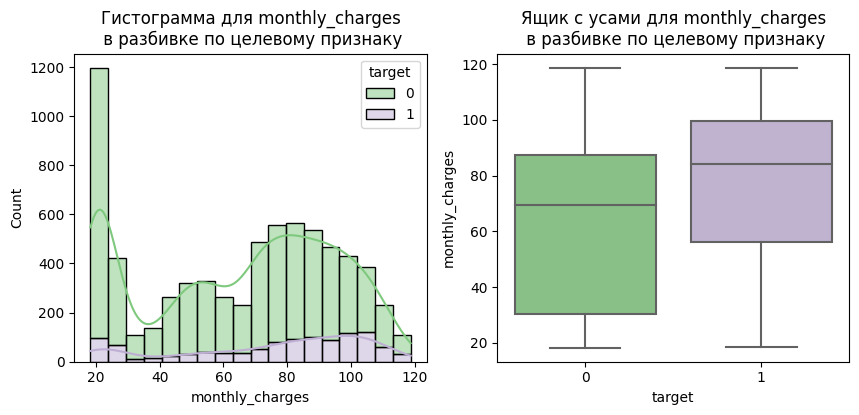

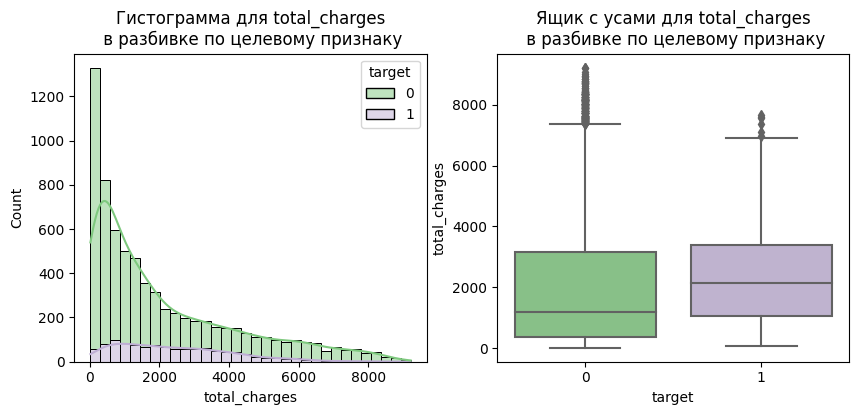

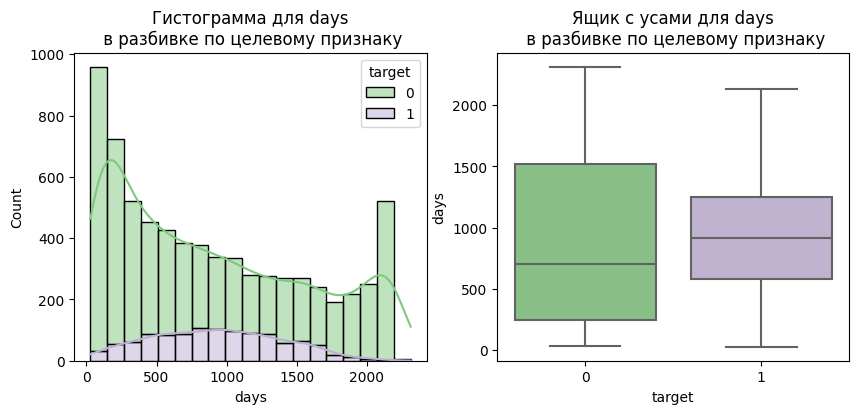

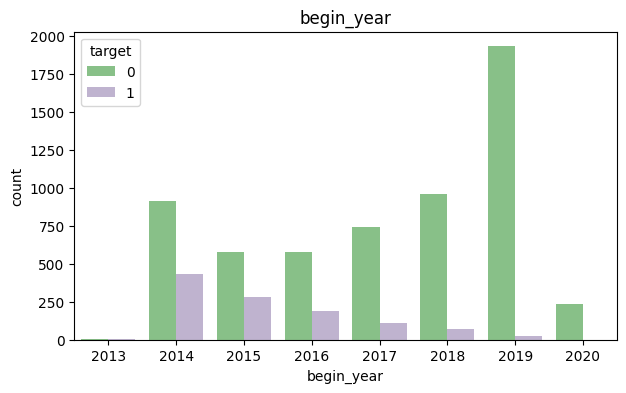

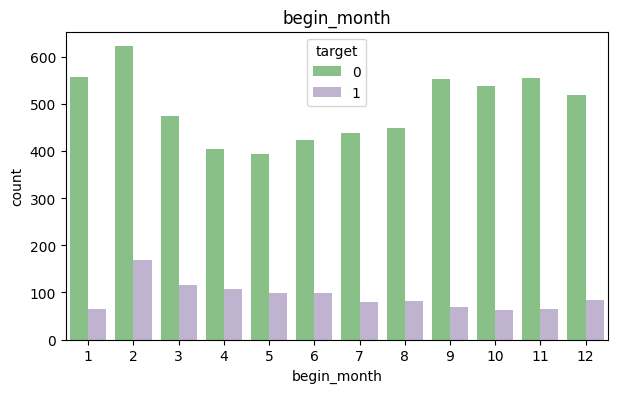

In [50]:
num_target_plot(data,'target', ['begin_year', 'begin_month']);

In [51]:
data[data['begin_year'] == 2019]['target'].mean()*100

1.2774655084312723

In [52]:
data.groupby('begin_year')['monthly_charges'].mean()

begin_year
2013    100.531250
2014     76.133743
2015     70.933744
2016     66.808781
2017     66.410888
2018     62.024854
2019     57.376980
2020     37.909013
Name: monthly_charges, dtype: float64

**Из представленных графиков видно, что медианнные значения ежемесячных платежей и суммарных расходов выше в группе ушедших клиентов.**  
**В целом имеется большая группа пользователей, которые пользуются услугами компании по минимуму, чьи расходы в месяц равны 20, а также небольшая группа клиентов с высокими суммарными расходами.**   
**В среднем клиенты пользовались услугами компании около 1000 дней до того, как расторгнуть договор.**  
**Важно отметить, что доля ушедших клиентов уменьшалась с каждым годом. В частности, в 2014 и 2015 годах договор расторгли около половины клиентов, а 2019 году доля ушедших клиентов составила менее 2%. С каждым годом наблюдается тенденция к снижению среднего размера ежемесячных платежей, что, вероятно, и привеко к снижению количества расторгнутых договоров.**   
**Корреляции между месяцем заключения договора и долей ушедших клиентов не наблюдается. Больше всего договоров было заключено в феврале.**  
**Также стоит отметить, что распределения месячных и суммарных расходов сильно отличаются от нормального.**

Изучим особенности остальных признаков в зависимости от целевого признака.

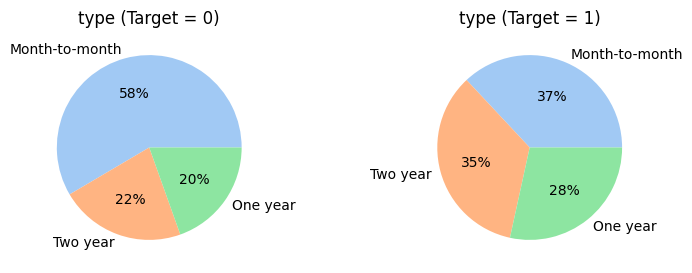

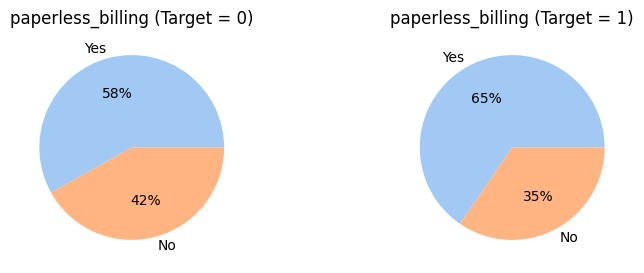

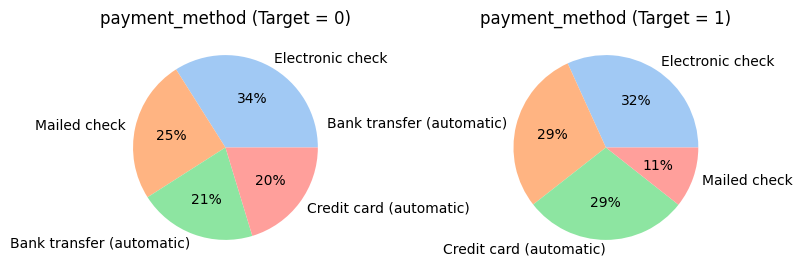

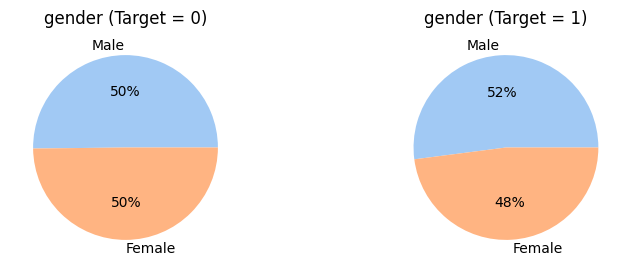

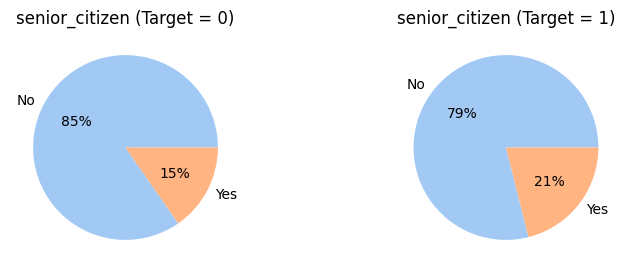

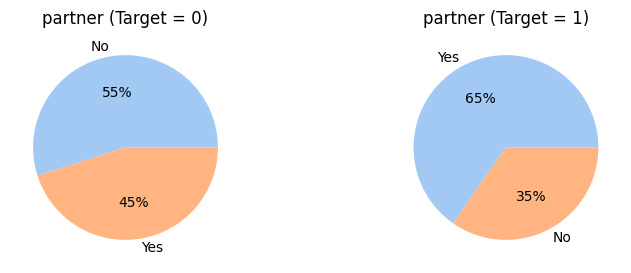

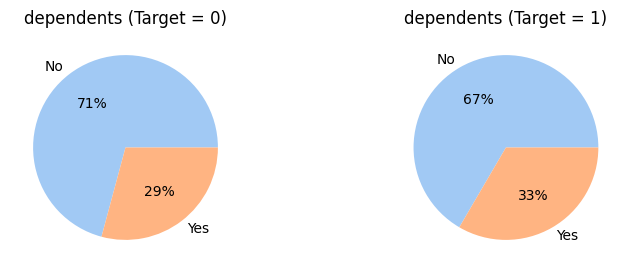

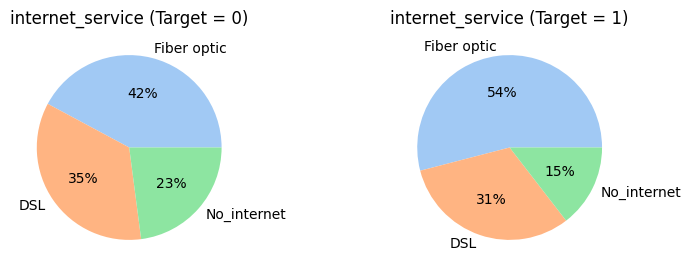

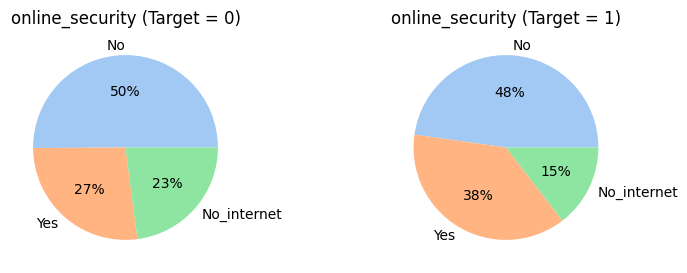

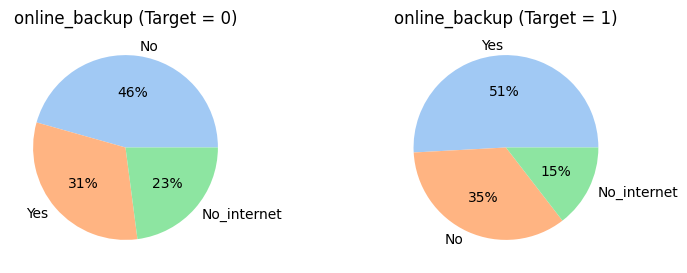

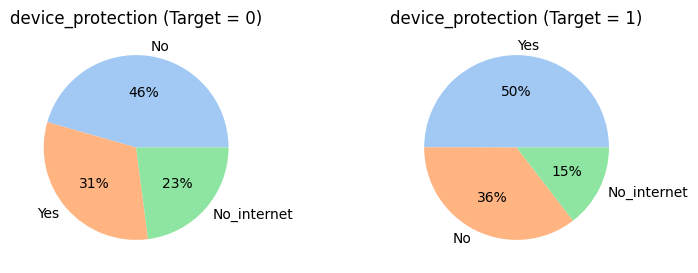

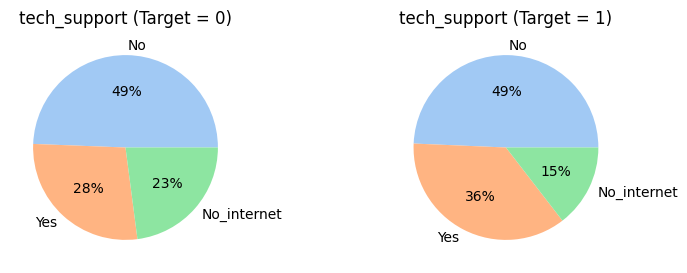

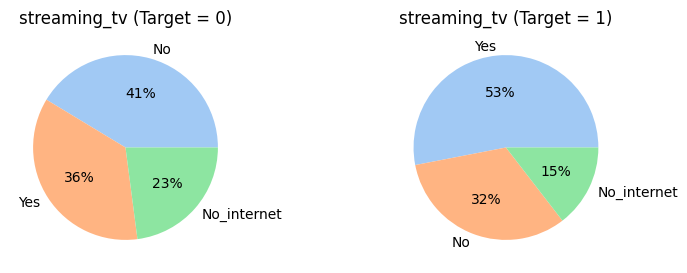

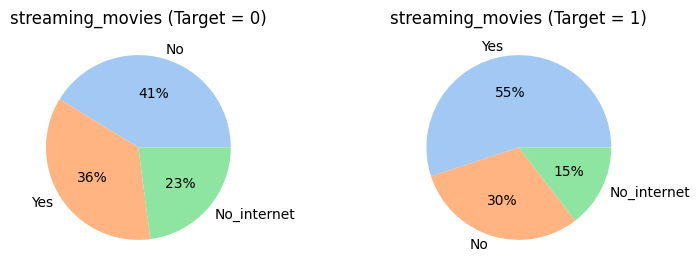

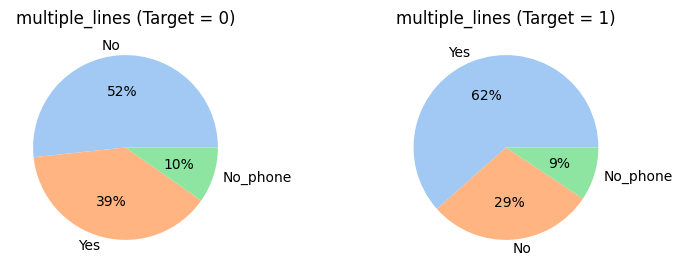

In [53]:
cat_target_plot(data, 'target')

**Наблюдаются явные отличия на диаграммах с периодичностью платежей у ушедших и оставшихся клиентов. В группе ушедших клиентов значительно выше доля платежей с периодичностью раз в год и раз в два года.**

**Также отмечается, что среди ушедших клиентов больше тех, кто согласился на получение электронного расчетного листа. Кроме того, в этой группе наблюдается более высокая доля автоплатежей (через банковский перевод и кредитные карты).**

**Доля мужчин и женщин в обеих группах практически одинакова. Однако среди ушедших клиентов выше процент пенсионеров, а также людей, состоящих в браке; также незначительно увеличен процент клиентов с детьми.**

**Что касается дополнительных услуг компании, то наиболее заметные различия наблюдаются по таким признакам, как online backup, device protection, streaming TV, streaming movies и multiple lines. В группе ушедших клиентов выше доля тех, кто согласился на подключение дополнительных опций. Учитывая данные факты, а также более высокие ежемесячные платежи в этой группе, можно предположить, что клиенты либо недовольны качеством предоставляемых дополнительных услуг, либо не используют их и недовольны переплатами.**


# Корреляционный анализ данных

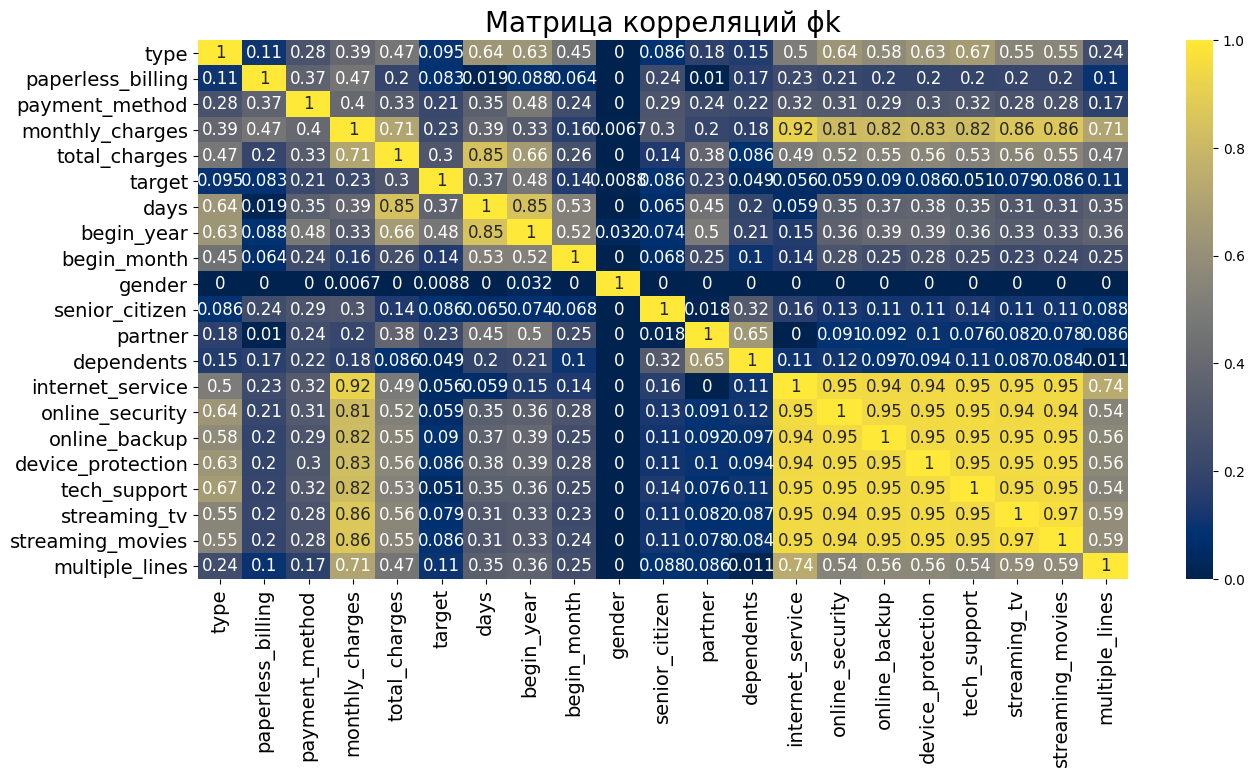

In [54]:
interval_cols=['monthly_charges', 'total_charges', 'days']
phik(data,interval_cols)

При проведении исследовательского анализа данных, было показано, что доля ушедших клиентов снижалась с каждым годом, что, вероятно связано с изменением условий договоров или изменением качества предоставляемых услуг. Поэтому для предсказания расторжения договора следует опираться не на дату, а на другие характеристики.
Считаю, что следует удалить признаки с годом и месяцем заключения договора.

In [55]:
data_2=data.copy()
data_2=data.drop(columns=['begin_year', 'begin_month'])

Наблюдается высокая корреляция между признаками, касающимися дополнительных интернет-услуг.  
На мой взгляд, можно создать новый признак с количеством подключенных дополнительных услуг вместо признаков 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'. 

In [56]:
internet_col_2 = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

data_2[internet_col_2] = data_2[internet_col_2].apply(lambda x: x.map({'Yes': 1, 'No': 0, 'No_internet': 0}))

In [57]:
data_2['number_of_services'] = data_2[internet_col_2].sum(axis=1)

In [58]:
data_2 = data_2.drop(columns=internet_col_2)

In [59]:
data_2.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,target,days,gender,senior_citizen,partner,dependents,internet_service,multiple_lines,number_of_services
customer_id,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,No,Yes,No,DSL,No_phone,1
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,Male,No,No,No,DSL,No,2
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,No,No,No,DSL,No,2
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,No,No,No,DSL,No_phone,3
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,No,No,No,Fiber optic,No,0


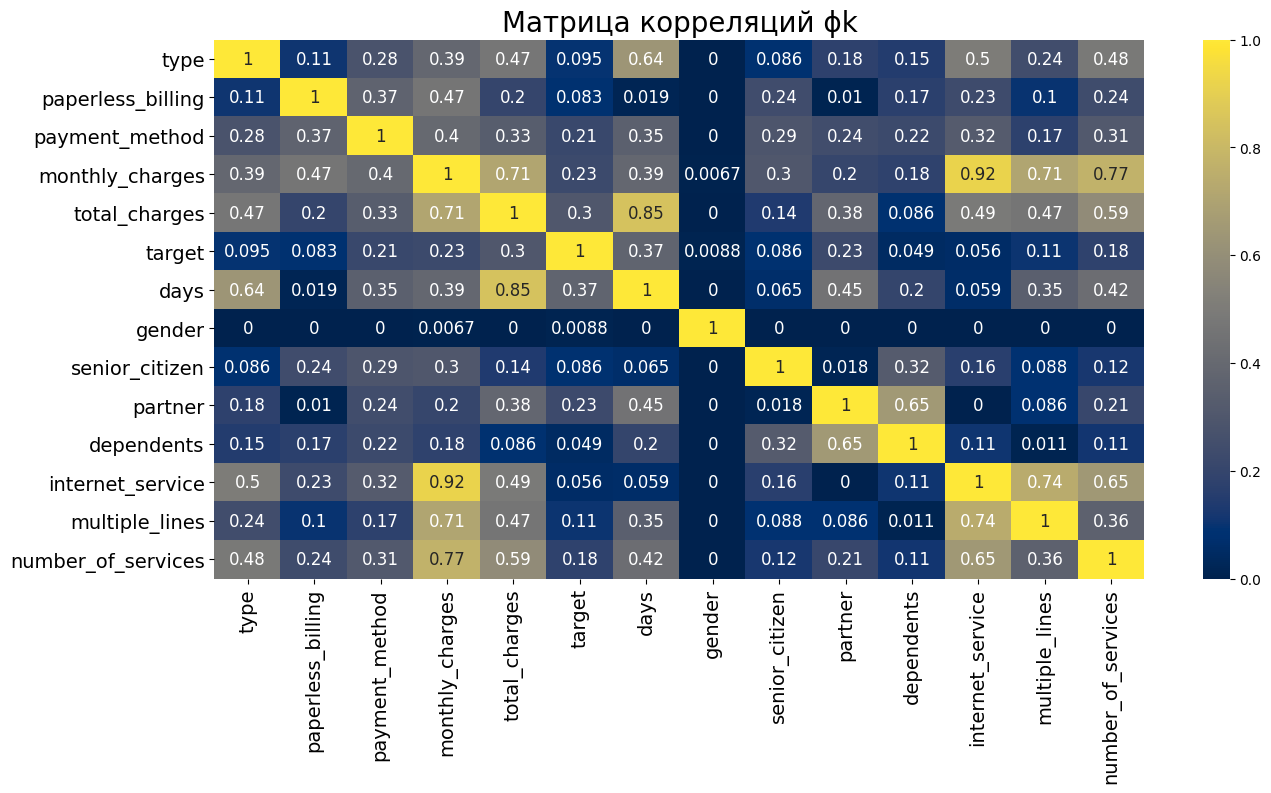

In [60]:
phik(data_2,interval_cols)

Наблюдается высокая корреляция признака montly_charges с  признаком internet_service,  поэтому линейные модели для решения задачи прогнозирования рассматриваться не будут.

**Вывод по корреляционному анализу данных:**  
**Была установлена высокая корреляция между признаками 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', в связи с чем было принято создать новый признак с количеством дополнительных услуг.**  
**Также установлено, что признак montly_charges сильно коррелирует с признаком internet_service, в связи с чем не рекомендуется использовать линейные модели для прогнозирования.**


# Обучение моделей

Разбивка данных на тренировочные и тестовые выборки:

In [61]:
X_train, X_test, y_train, y_test = df_split(data_2, 'target')

Размер тренировочных выборок: (5274, 13), (5274,).    Размер тестовых выборок (1758, 13), (1758,)


Кодирование признаков:

In [62]:
ohe_columns = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen',
               'partner', 'dependents', 'internet_service', 'multiple_lines'
              ]
X_train_encoded, X_test_encoded = ohe(X_train, X_test, ohe_columns)

In [63]:
X_train_encoded.head()

,monthly_charges,total_charges,days,number_of_services,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,senior_citizen_Yes,partner_Yes,dependents_Yes,internet_service_Fiber optic,internet_service_No_internet,multiple_lines_No_phone,multiple_lines_Yes
customer_id,,,,,,,,,,,,,,,,,,
8305-VHZBZ,20.20,101.00,153,0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6532-YLWSI,20.80,792.69,1126,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2657-VPXTA,88.85,888.50,306,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3244-DCJWY,70.25,281.00,123,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0519-XUZJU,70.75,283.00,123,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## DecisionTreeClassifier

Обучение модели DecisionTreeClassifier с перебором гиперпараметров:

In [64]:
model_dt = DecisionTreeClassifier(random_state = RANDOM_STATE, class_weight = 'balanced')
param_dt = [
        {
        'max_depth': range(2, 11),
        'min_samples_split': range(2, 7),  
        'min_samples_leaf': range(1, 6)
        }
]
gs_dt = GridSearchCV(
    model_dt,
    param_dt,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc')

gs_dt.fit(X_train_encoded, y_train)

print('Оптимальные параметры DecisionTreeClassifier:\n\n',gs_dt.best_estimator_)
print ('Метрика roc_auc лучшей модели DecisionTreeClassifier на тренировочной выборке:', (gs_dt.best_score_).round(2))

Оптимальные параметры DecisionTreeClassifier:

 DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       random_state=231224)
Метрика roc_auc лучшей модели DecisionTreeClassifier на тренировочной выборке: 0.79


C:\Users\knadi\anaconda3\envs\practicum\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


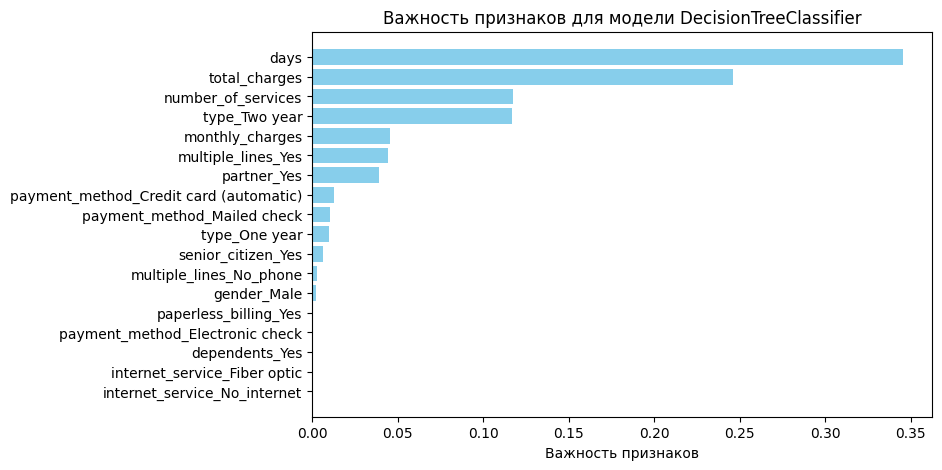

In [65]:
plot_feature_importances(gs_dt.best_estimator_, X_train_encoded.columns,'DecisionTreeClassifier')

## RandomForestClassifier

In [68]:
model_rf = RandomForestClassifier(random_state = RANDOM_STATE, class_weight = 'balanced')
param_rf = [
        {
        'n_estimators': [50, 100, 150], 
        'max_depth': range(5, 16, 2),  
        'min_samples_split': range(2, 6),  
        'min_samples_leaf': range(1, 4)
        }
]
gs_rf = GridSearchCV(
    model_rf,
    param_rf,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc')

gs_rf.fit(X_train_encoded, y_train)

print('Оптимальные параметры RandomForestClassifier:\n\n',gs_rf.best_estimator_)
print ('Метрика roc_auc лучшей модели RandomForestClassifier на тренировочной выборке:', (gs_rf.best_score_).round(2))

Оптимальные параметры RandomForestClassifier:

 RandomForestClassifier(class_weight='balanced', max_depth=9, min_samples_leaf=3,
                       n_estimators=150, random_state=231224)
Метрика roc_auc лучшей модели RandomForestClassifier на тренировочной выборке: 0.82


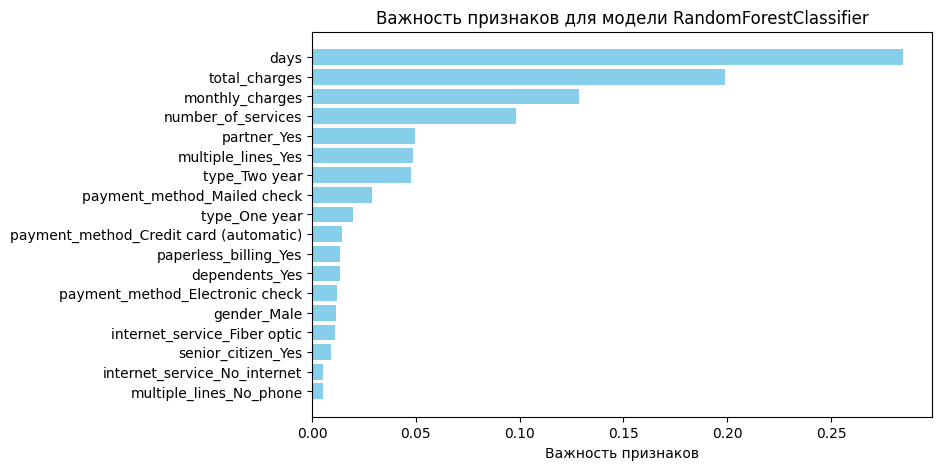

In [69]:
plot_feature_importances(gs_rf.best_estimator_, X_train_encoded.columns,'RandomForestClassifier')

Модель RandomForestClassifier превосходит по качеству модель DecisionTreeClassifier. 

## CatBoostClassifier

Для данной модели будут использованы признаки без кодировки.

In [72]:
model_cat = CatBoostClassifier(random_state = RANDOM_STATE, auto_class_weights='Balanced')

cat_features = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen',
               'partner', 'dependents', 'internet_service', 'multiple_lines'
               ]
for col in cat_features:
   
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

cv_cat = cross_val_score(
    model_cat,
    X_train,
    y_train,
    scoring='roc_auc',  
    cv=5,
    fit_params={'cat_features': cat_features}
)

print('Среднее значение метрики roc_auc на кросс-валидации для модели CatBoostClassifier', cv_cat.mean().round(2))

Learning rate set to 0.01905


C:\Users\knadi\anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


0:	learn: 0.6877565	total: 178ms	remaining: 2m 57s
1:	learn: 0.6825480	total: 234ms	remaining: 1m 56s
2:	learn: 0.6763468	total: 302ms	remaining: 1m 40s
3:	learn: 0.6706411	total: 357ms	remaining: 1m 28s
4:	learn: 0.6646901	total: 389ms	remaining: 1m 17s
5:	learn: 0.6592449	total: 437ms	remaining: 1m 12s
6:	learn: 0.6538773	total: 479ms	remaining: 1m 7s
7:	learn: 0.6489939	total: 522ms	remaining: 1m 4s
8:	learn: 0.6439678	total: 569ms	remaining: 1m 2s
9:	learn: 0.6393799	total: 621ms	remaining: 1m 1s
10:	learn: 0.6354695	total: 679ms	remaining: 1m 1s
11:	learn: 0.6312090	total: 740ms	remaining: 1m
12:	learn: 0.6274104	total: 796ms	remaining: 1m
13:	learn: 0.6236387	total: 859ms	remaining: 1m
14:	learn: 0.6192438	total: 919ms	remaining: 1m
15:	learn: 0.6167822	total: 965ms	remaining: 59.3s
16:	learn: 0.6125132	total: 1.03s	remaining: 59.8s
17:	learn: 0.6087836	total: 1.11s	remaining: 1m
18:	learn: 0.6056039	total: 1.18s	remaining: 1m
19:	learn: 0.6025180	total: 1.25s	remaining: 1m 1s
20

Максимальное значение метрики ROC-AUC получено с использованием модели CatBoostClassifier. 
Для улучшения качества прогнозов можно использовать подбор гиперапараметров.

In [73]:
param_cat = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.03, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}



gs_cat = RandomizedSearchCV(
    model_cat,
    param_cat,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    random_state = RANDOM_STATE
)


gs_cat.fit(X_train, y_train, cat_features=cat_features)

print('Оптимальные параметры CatBoostClassifier:',gs_cat.best_estimator_)
print ('Метрика roc_auc лучшей модели CatBoostClassifier на тренировочной выборке:', (gs_cat.best_score_).round(2))

0:	learn: 0.6692854	total: 33.5ms	remaining: 33.4s
1:	learn: 0.6452005	total: 69.1ms	remaining: 34.5s
2:	learn: 0.6262569	total: 100ms	remaining: 33.3s
3:	learn: 0.6088827	total: 130ms	remaining: 32.5s
4:	learn: 0.5937008	total: 150ms	remaining: 29.9s
5:	learn: 0.5827118	total: 169ms	remaining: 28s
6:	learn: 0.5746426	total: 192ms	remaining: 27.2s
7:	learn: 0.5674185	total: 226ms	remaining: 28.1s
8:	learn: 0.5635794	total: 256ms	remaining: 28.2s
9:	learn: 0.5576469	total: 295ms	remaining: 29.2s
10:	learn: 0.5511717	total: 335ms	remaining: 30.1s
11:	learn: 0.5472788	total: 377ms	remaining: 31s
12:	learn: 0.5413201	total: 413ms	remaining: 31.4s
13:	learn: 0.5367513	total: 454ms	remaining: 32s
14:	learn: 0.5326228	total: 497ms	remaining: 32.6s
15:	learn: 0.5306075	total: 541ms	remaining: 33.3s
16:	learn: 0.5278322	total: 585ms	remaining: 33.8s
17:	learn: 0.5239603	total: 634ms	remaining: 34.6s
18:	learn: 0.5222072	total: 665ms	remaining: 34.3s
19:	learn: 0.5178644	total: 709ms	remaining: 

In [74]:
results = pd.DataFrame(gs_cat.cv_results_)
results.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_l2_leaf_reg,param_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,69.595058,0.471548,0.023000,0.003498,0.10,3,4,"{'learning_rate': 0.1, 'l2_leaf_reg': 3, 'dept...",0.905707,0.893531,0.895376,0.928375,0.886941,0.901986,0.014503,1
1,64.541006,0.518828,0.027874,0.005622,0.10,5,4,"{'learning_rate': 0.1, 'l2_leaf_reg': 5, 'dept...",0.904372,0.893687,0.895499,0.927907,0.885203,0.901334,0.014616,2
2,93.936093,3.577630,0.024135,0.002954,0.10,3,6,"{'learning_rate': 0.1, 'l2_leaf_reg': 3, 'dept...",0.896997,0.886708,0.887845,0.925705,0.885714,0.896594,0.015102,3
7,64.082718,1.015800,0.022281,0.003848,0.03,1,4,"{'learning_rate': 0.03, 'l2_leaf_reg': 1, 'dep...",0.881811,0.864889,0.865461,0.913054,0.874561,0.879955,0.017692,4
8,61.762738,3.140842,0.017038,0.005044,0.03,3,4,"{'learning_rate': 0.03, 'l2_leaf_reg': 3, 'dep...",0.886885,0.864590,0.859333,0.910892,0.864615,0.877263,0.019316,5


Подбор гиперпараметров для модели CatBoostClassifier позволил повысить значение метрики ROC AUC с 0.87 до 0.90.

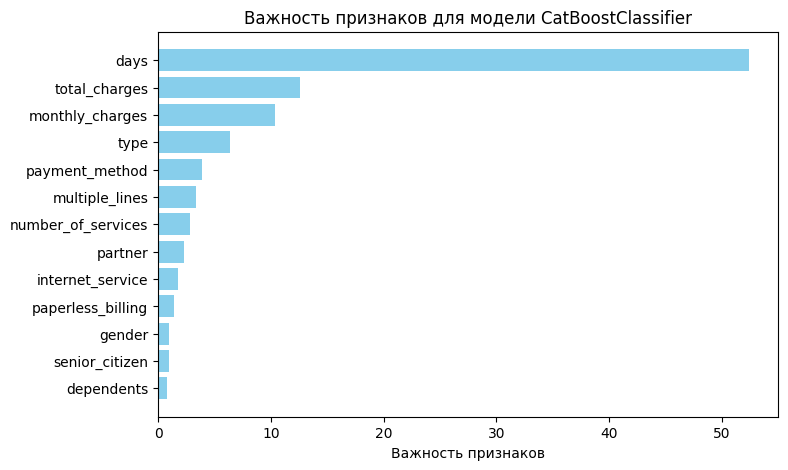

In [75]:
plot_feature_importances(gs_cat.best_estimator_, X_train.columns,'CatBoostClassifier')

Важно отметить, что результаты анализа важности признаков в целом согласуются с корреляционным и исследовательским анализом.

**Было обучено 3 модели для прогнозирования оттока клиентов: DecisionTreeClassifier, RandomForestClassifier и CatBoostClassifier. Максимальное значение метрики ROC-AUC (0.91) получено с использованием модели CatBoostClassifier со следующими гиперпараметрам: depth=4, l2_leaf_reg=3, learning_rate=0.1 (остальные гиперпараметры по умолчанию). Данная модель будет проверена с помощью тестовой выборки.**

# Анализ лучшей модели

Проверка модели на тестовой выборке:

In [80]:
y_test_pred = gs_cat.best_estimator_.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:,1]).round(2)}')

Метрика ROC-AUC на тестовой выборке: 0.91


Значение метрики ROC-AUC осталось на том же уровне, что и при обучении модели, что свидетельствует о высоком качестве прогнозов и отсутствии переобучения.

Проверка модели на адекватность:

In [81]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state = RANDOM_STATE)

dummy_clf.fit(X_train, y_train)

y_test_pred_clf = dummy_clf.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке модели DummyClassifier: {roc_auc_score(y_test, y_test_pred_clf[:,1]).round(2)}')

Метрика ROC-AUC на тестовой выборке модели DummyClassifier: 0.5


При предсказании наиболее часто встречающимся классом мы наблюдаем значительное снижение метрики, что свидетельствует об адекватности модели CatBoostClassifier.

# Вывод

**Выполнены все запланированные этапы работы.**  
**Проведена предварительная обработка данных, в результате которой было проведено объединение данных и заполнение пропусков. Сгенерированы новые признаки, которые использовались при обучении моделей, в частности, количество дней пользования услугами компании, количество подключенных дополнительных услуг.**  
**Проведен исследовательский анализ данных, в котором были продемонстрированы различия для двух категорий пользователей. В частности, показано, что в группе ушедших клиентов выше ежемесячные платежи, выше доля платежей с периодичностью раз в год и раз в два года, также в этой группе наблюдается более высокая доля автоплатежей. В группе ушедших клиентов выше доля тех, кто согласился на подключение дополнительных опций. В среднем клиенты пользовались услугами компании около 1000 дней до того, как расторгнуть договор.**  
**Обнаружено, что с каждым годом  происходит прирост общего количества клиентов, а доля клиентов, которые расторгли договор, заметно снижается. В частности, в 2014 и 2015 годах договор расторгли около половины клиентов, а 2019 году доля ушедших клиентов составила менее 2%. Также наблюдается тенденциия к снижению среднего размера ежемесячных платежей с 2013 по 2020 годы. Причину таких изменений стоит уточнить у сотрудников компании "ТелеДом", возможно, были проведены какие-либо рекламные кампании, предоставлены скидки и т.п. После чего, возможно, стоит исключить из анализа данные за первые годы существания компании, если были проведены какие-либо существенные изменения в условиях предоставления услуг.**  
**Было обучено 3 модели для прогнозирования оттока клиентов. Для решения данной задачи можно рекомендовать модель CatBoostClassifier, которая показала высокое каачество предсказаний на тренировочных и тестовых данных.**